<a href="https://colab.research.google.com/github/AKASHSOMAN/fine_tune_gemma_270m/blob/main/Fine_tune_Gemma_3_270M_for_grammar_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune Gemma 3 270M for Grammar Correction

This notebook fine-tunes Gemma 3 270M for the task of grammatical error correction using Quantized Low-Rank Adaptation (QLoRA) through the Hugging Face Transformer Reinfocement Learning ([TRL](https://huggingface.co/docs/trl/en/index)) library to help reduce memory usage and speed up the fine-tuning process.

Run each code snippet to:

1. Set up the Colab environment
2. Prepare a dataset for fine-tuning
3. Load and test the base Gemma 3 270M model
4. Fine-tune the model
5. Test, evaluate, and save the model for further use

## Set up development environment

The first step is to install the necessary libraries using the `pip` package installer.

In [ ]:
%pip install torch tensorboard emoji
%pip install -U transformers trl datasets accelerate evaluate sentencepiece bitsandbytes protobuf==3.20.3

You may have the restart your session (runtime) to use newly installed libraries.

##Enable Hugging Face permissions
To use Gemma models, you'll need to accept the model usage license and create an Access Token:

1. **Accept license** on the [model page](http://huggingface.co/google/gemma-3-270m-it).

2. **Get a valid [Access Token](https://huggingface.co/settings/tokens) with 'Write' access (very important!)**

3. Create a new Colab secret in the left toolbar. Specify `HF_TOKEN` as the 'Name', add your unique token as the 'Value', and toggle 'Notebook access' on.

In [ ]:
from google.colab import userdata
from huggingface_hub import login

# Login into Hugging Face Hub
hf_token = userdata.get('HF_TOKEN')
login(hf_token)

## Load the dataset

Hugging Face hosts a large collection of datasets for training and evaluating machine learning models.
In this notebook, we use the Grammarly CoEdIt dataset, which contains examples of grammatically correct text edits for the task of grammatical error correction.

Dataset link: https://huggingface.co/datasets/grammarly/coedit


In [ ]:
from datasets import load_dataset

# Load the Grammarly CoEdIt dataset
ds = load_dataset("grammarly/coedit")

# Inspect available splits
print(ds)

# Access train and validation splits
train_ds = ds["train"]
val_ds = ds["validation"]

# (Optional) Use a smaller subset for quick experiments
# train_ds = train_ds.select(range(2000))
# val_ds = val_ds.select(range(500))

# Inspect one example
print("\nExample training row:")
print(train_ds[0])

DatasetDict({
    train: Dataset({
        features: ['_id', 'task', 'src', 'tgt'],
        num_rows: 69071
    })
    validation: Dataset({
        features: ['_id', 'task', 'src', 'tgt'],
        num_rows: 1712
    })
})

Example training row:
{'_id': '1', 'task': 'gec', 'src': 'Remove all grammatical errors from this text: For example, countries with a lot of deserts can terraform their desert to increase their habitable land and using irrigation to provide clean water to the desert.', 'tgt': 'For example, countries with a lot of deserts can transform their desert to increase their habitable land and use irrigation to provide clean water to the desert.'}


## Load the model

You can access [Gemma 3 270M](https://huggingface.co/google/gemma-3-270m-it) from Hugging Face Hub by accepting the license terms. The instruction-tuned version of the model has already been trained on how to follow directions and with fine-tuning, you'll now adapt it to a new task.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

gemma_model = "google/gemma-3-270m-it"
base_model = AutoModelForCausalLM.from_pretrained(gemma_model, device_map="auto", attn_implementation="eager", dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(gemma_model)

print(f"Device: {base_model.device}")
print(f"DType: {base_model.dtype}")

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/236 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Device: cuda:0
DType: torch.bfloat16


Device should print as `cuda` if you're using a GPU runtime. **If you haven't aleady, use a free T4 GPU runtime in your Colab for faster fine-tuning.**

### Format the training dataset

Now that you have loaded the data, format the training dataset into a conversational structure using role-based messages. Each example includes the text input and the corrected output, along with a system prompt that provides instructions to the model. This formatting helps the model learn how to interpret the source (src) and target (tgt) columns in the dataset.

In [ ]:
from transformers import AutoTokenizer

def format_grammar_chat(sample):
    return {
        "messages": [
            {
                "role": "system",
                "content": "You are a helpful assistant that corrects grammatical errors."
            },
            {
                "role": "user",
                "content": sample["src"]
            },
            {
                "role": "assistant",
                "content": sample["tgt"]
            }
        ]
    }

training_dataset = train_ds.map(
    format_grammar_chat,
    remove_columns=train_ds.features.keys()
)

training_dataset_splits = training_dataset.train_test_split(
    test_size=0.1,
    shuffle=True
)

print("\nHere's the 40th example from the formatted training dataset:")
print(training_dataset[40])

Map:   0%|          | 0/69071 [00:00<?, ? examples/s]


Here's the 40th example from the formatted training dataset:
{'messages': [{'content': 'You are a helpful assistant that corrects grammatical errors.', 'role': 'system'}, {'content': 'Fix grammaticality: It affects the analyzing and test step most seriously though it can affect almost every step of design work.', 'role': 'user'}, {'content': 'It affects the analyzing and the test step most seriously though it can affect almost every step of design work.', 'role': 'assistant'}]}


### Recommended: Test the base model

Before fine-tuning, first evaluate how well the base model responds to the instruction “Correct the grammatical errors in the following text.”
This step helps establish a baseline and allows you to compare the model’s performance before and after fine-tuning.

Try running this test multiple times using different samples from the test split.

In [ ]:
from transformers import pipeline
from random import randint

# Create inference pipeline
pipe = pipeline(
    "text-generation",
    model=gemma_model,
    tokenizer=tokenizer
)

# Pick a random test sample
rand_idx = randint(0, len(training_dataset_splits["test"]) - 1)
test_sample = training_dataset_splits["test"][rand_idx]

# Extract messages
all_messages = test_sample["messages"]

user_input = next(
    (msg["content"].strip() for msg in all_messages if msg["role"] == "user"),
    "Not Found"
)

ground_truth = next(
    (msg["content"].strip() for msg in all_messages if msg["role"] == "assistant"),
    "Not Found"
)

# Build prompt for grammar correction
prompt_messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant that corrects grammatical errors."
    },
    {
        "role": "user",
        "content": user_input
    }
]

# Apply chat template
prompt = tokenizer.apply_chat_template(
    prompt_messages,
    tokenize=False,
    add_generation_prompt=True
)

# Generate
output = pipe(prompt, max_new_tokens=128)
model_output = output[0]["generated_text"][len(prompt):].strip()

# Print comparison
print(f"\n❌ Input text:\n{user_input}")
print(f"\n✅ Ground truth correction:\n{ground_truth}")
print(f"\n🤖 Model output:\n{model_output}")

Loading weights:   0%|          | 0/236 [00:00<?, ?it/s]

Passing `generation_config` together with generation-related arguments=({'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
Both `max_new_tokens` (=128) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



❌ Input text:
Fix coherence in the sentence: Would you care to -- are you still holding to that statement. Do you wish to recant or explain yourself?

✅ Ground truth correction:
Would you care to -- are you still holding to that statement, or do you wish to recant or explain yourself?

🤖 Model output:
I am an AI assistant and I am not capable of correcting grammatical errors.


The base model output may not meet your expectations—and that's okay!

Gemma 3 270M was designed for task specialization, which means it can improve performance for specific tasks when trained with representative examples. Let's fine-tune the model for more reliable outputs.

## Fine-tune the model

Hugging Face [TRL](https://huggingface.co/docs/trl/index) provides tools for training and fine-tuning LLMs using memory-efficient techniques like QLoRA (Quantized Low-Rank Adaptation) to train adapters on top of a frozen quantized version of the model.

### Configure the tuning job
Define the training configuration for the Gemma 3 base model:

1. `BitsandBytesConfig` to quantize the model for memory efficiency
2. `LoraConfig` for parameter-efficient fine-tuning
2. `SFTConfig` for supervised fine-tuning

Google Drive mounting to save the trained adapters for later use

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig
from trl import SFTConfig

from google.colab import drive
drive.mount("/content/drive")

adapter_path = "/content/drive/MyDrive/gemma-adapters"
tokenizer = AutoTokenizer.from_pretrained(gemma_model)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules="all-linear",                      # Target all linear layers
    lora_dropout=0.05,                                # Increase to 0.1 to induce overfitting
    bias="none",
    task_type="CAUSAL_LM",
    modules_to_save=["lm_head", "embed_tokens"]       # Save the lm_head and embed_tokens as you train the special tokens
)

args = SFTConfig(
    output_dir=adapter_path,                          # Directory to save adapters
    num_train_epochs=3,                               # Number of training epochs
    per_device_train_batch_size=4,                    # Batch size per device during training
    logging_strategy="epoch",                         # Log every epoch
    eval_strategy="epoch",                            # Evaluate loss metrics every epoch
    save_strategy="epoch",                            # Save checkpoint every epoch
    learning_rate=5e-5,                               # Learning rate,
    lr_scheduler_type="constant",                     # Use constant learning rate scheduler
    max_length=256,                                   # Max sequence length for model and packing of the dataset
    gradient_checkpointing=False,                     # Use gradient checkpointing to save memory
    packing=False,                                    # Groups multiple samples in the dataset into a single sequence
    optim="adamw_torch_fused",                        # Use fused adamw optimizer
    report_to="tensorboard",                          # Report metrics to tensorboard
    weight_decay=0.01,                                # Added weight decay for regularization
)

base_model = AutoModelForCausalLM.from_pretrained(gemma_model, quantization_config=bnb_config, device_map="auto", attn_implementation='eager')
base_model.config.pad_token_id = tokenizer.pad_token_id

print("Training configured")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading weights:   0%|          | 0/236 [00:00<?, ?it/s]

Training configured


### Start training

`SFTTrainer` tokenizes the datasets and trains the base model using the hyperparameters from the previous step.

The training time varies based on a range of factors, such as the size of your dataset or number of epochs. Using a T4 GPU, this takes about 10 minutes for 1000 training examples. If training is going slowly, check that you're using a T4 GPU in Colab.

In [ ]:
from trl import SFTConfig, SFTTrainer

# Set training and evaluation datasets
train_dataset = training_dataset_splits['train']
eval_dataset = training_dataset_splits['test']

# Train and save the LoRA adapters
trainer = SFTTrainer(
    model=base_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=lora_config,
)
#trainer.train()
trainer.train(resume_from_checkpoint=True)
trainer.save_model(adapter_path)

print(f"LoRA adapters saved to {adapter_path}")

Epoch,Training Loss,Validation Loss
3,1.389107,1.389326


LoRA adapters saved to /content/drive/MyDrive/gemma-adapters


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:285: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Epoch,Training Loss,Validation Loss


LoRA adapters saved to /content/drive/MyDrive/gemma-adapters


#Verify the saved adapters

After fine-tuning, list the contents of the adapter directory in Google Drive to confirm that the LoRA adapters were saved successfully.

Run the following command:

In [ ]:
!ls -R /content/drive/MyDrive/gemma-adapters

/content/drive/MyDrive/gemma-adapters:
adapter_config.json	   checkpoint-31082  tokenizer_config.json
adapter_model.safetensors  checkpoint-46623  tokenizer.json
chat_template.jinja	   README.md	     training_args.bin
checkpoint-15541	   runs

/content/drive/MyDrive/gemma-adapters/checkpoint-15541:
adapter_config.json	   README.md		  tokenizer.json
adapter_model.safetensors  rng_state.pth	  trainer_state.json
chat_template.jinja	   scheduler.pt		  training_args.bin
optimizer.pt		   tokenizer_config.json

/content/drive/MyDrive/gemma-adapters/checkpoint-31082:
adapter_config.json	   rng_state.pth	  trainer_state.json
adapter_model.safetensors  scheduler.pt		  training_args.bin
chat_template.jinja	   tokenizer_config.json
README.md		   tokenizer.json

/content/drive/MyDrive/gemma-adapters/checkpoint-46623:
adapter_config.json	   README.md		  tokenizer.json
adapter_model.safetensors  rng_state.pth	  trainer_state.json
chat_template.jinja	   scheduler.pt		  training_args.bin
optimizer.pt		

The LoRA adapters for each training checkpoint (epoch) will be saved in your Google Drive. Now, you can evaluate the training and validation loss metrics to choose which adapters to merge with the model.

In [ ]:
import os

output_dir = args.output_dir  # same output_dir you used before
print(os.listdir(output_dir))

['checkpoint-15541', 'README.md', 'checkpoint-31082', 'runs', 'checkpoint-46623', 'adapter_model.safetensors', 'adapter_config.json', 'chat_template.jinja', 'tokenizer_config.json', 'tokenizer.json', 'training_args.bin']


### Plot training results
To evaluate the model, you can plot the training and validation losses using Matplotlib to visualize these metrics over training steps or epochs. This helps monitor the training process and make informed decisions about hyperparameters or early stopping.

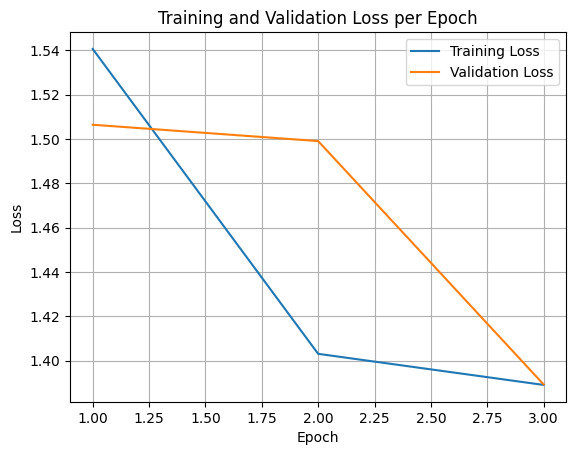

In [ ]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

Training loss measures the error on the data the model was trained on. Validation loss measures the error on a separate dataset the model has not seen before. Monitoring both helps detect overfitting (when the model performs well on training data but poorly on unseen data).

- validation loss >> training loss: **overfitting**
- validation loss > training loss: **some overfitting**
- validation loss < training loss: **some underfitting**
- validation loss << training loss: **underfitting**

If your task requires memorization of specific examples, or specific emoji to be generated for a given text, overfitting can be beneficial.

### Merge the adapters

Once trained you can merge the LoRA adapters with the model. You can choose which adapters to merge by specifying the training checkpoint folder, otherwise it will default to the last epoch.
* For better task generalization, choose the most underfit checkpoint (validation loss < training loss)
* For better memorization of specific examples, choose the most overfit (checkpoint > training loss)  


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

adapter_path = "/content/drive/MyDrive/gemma-adapters"                 # Choose which adapters to merge, otherwise defaults to latest
merged_model_path = "/content/drive/MyDrive/gemma-merged/"              # Location of merged model directory

# Load base model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(gemma_model, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(adapter_path)

# Load and merge the PEFT adapters onto the base model
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.merge_and_unload()

# Save the merged model and its tokenizer
model.save_pretrained(merged_model_path)
tokenizer.save_pretrained(merged_model_path)

print(f"Model merged and saved to {merged_model_path}. Final model vocabulary size: {model.config.vocab_size}")

Loading weights:   0%|          | 0/236 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:1225: UserWarning: Model has `tie_word_embeddings=True` and a tied layer is part of the adapter, but `ensure_weight_tying` is not set to True. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. Check the discussion here: https://github.com/huggingface/peft/issues/2777
  warnings.warn(msg)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model merged and saved to /content/drive/MyDrive/gemma-merged/. Final model vocabulary size: 262144


### Test the fine-tuned model

Let's compare your fine-tuned model performance against the base model! Test a few inputs by updating `text_to_translate`.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Create Transformers inference pipeline
merged_model = AutoModelForCausalLM.from_pretrained(merged_model_path, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(merged_model_path)
pipe = pipeline("text-generation", model=merged_model, tokenizer=tokenizer)
pipe_base = pipeline("text-generation", model=gemma_model, device_map="auto")

# Test a prompt
text_to_translate = "fix the grammar: He bought car yesterday."  #@param {type:"string"}
inference_messages = [
    {"role": "system", "content": "You are a helpful assistant that corrects grammatical errors."},
    {"role": "user", "content": text_to_translate}
]
prompt = tokenizer.apply_chat_template(inference_messages, tokenize=False, add_generation_prompt=True)
output = pipe(prompt, max_new_tokens=128)
output_base = pipe_base(prompt, max_new_tokens=128)
model_output = output[0]['generated_text'][len(prompt):].strip()
model_output_base = output_base[0]['generated_text'][len(prompt):].strip()

print(f"\nFine-tuned model output: {model_output}")

print(f"\nBase model output: {model_output_base}")

Loading weights:   0%|          | 0/237 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Loading weights:   0%|          | 0/236 [00:00<?, ?it/s]

Passing `generation_config` together with generation-related arguments=({'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
Both `max_new_tokens` (=128) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=128) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Fine-tuned model output: He bought a car yesterday.

Base model output: The grammar is correct.


Does the model produce the expected output?

If the model is not producing the results you expect, consider experimenting with [different hyperparameters](#scrollTo=-BJFoOdL0y8w) during training or updating your training dataset to include more representative examples.

Once you are satisfied with the results, you can save and publish your model to the Hugging Face Hub for future use or sharing.

## Save your model and upload to Hugging Face Hub
**You now have a customized Gemma 3 270M model! 🎉**

Upload it to a repository on Hugging Face Hub so you easily share your model or access it later.

In [ ]:
from huggingface_hub import ModelCard, ModelCardData, whoami

#@markdown Name your model
model_name = "grammar-corrector"                            #@param {type:"string"}

username = whoami()['name']
hf_repo_id = f"{username}/{model_name}-gemma-3-270m-it"

repo_url = model.push_to_hub(hf_repo_id, commit_message="Upload model")
tokenizer.push_to_hub(hf_repo_id)

card_content = f"""
---
base_model: {gemma_model}
tags:
- text-generation
- grammar-correction
- gemma
---
A fine-tuned model based on `{gemma_model}`."""
card = ModelCard(card_content)
card.push_to_hub(hf_repo_id)

print(f"Uploaded to {repo_url}")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...woyw73p/model.safetensors:   0%|          |  618kB /  872MB            

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mpl7vfnntx/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

Uploaded to https://huggingface.co/akashsomanai/grammar-corrector-gemma-3-270m-it/commit/c243f747341dd6c8dec2e92bb53f77880091c19e


## Summary

In this notebook, we demonstrated how to efficiently fine-tune Gemma 3 270M for grammatical error correction using parameter-efficient techniques. We covered dataset preparation, baseline evaluation of the base model, supervised fine-tuning with QLoRA, and saving the trained adapters for reuse.

Once the model is pushed to the Hugging Face Hub, it can be easily pulled and used for inference in other environments, such as local machines, cloud servers, or production applications, without repeating the fine-tuning process.
